# Spatial Relations

## Introduction

Spatial Relations specify how objects are located in space relative to one another. [Spatial relations](https://en.wikipedia.org/wiki/Spatial_relation) are the results of questions like:
- what is the _distance_ between two locations?
- is location A _within_ area B?
- does area B _contain_ location A?
- do areas A and B _overlap_ ?

More examples of spatial relations are visualised in [the image](https://commons.wikimedia.org/wiki/File:TopologicSpatialRelarions2.png) below:

<center><img src="../../data/img/TopologicSpatialRelarions2.png"width=600/>
[<a href="https://commons.wikimedia.org/wiki/File:TopologicSpatialRelarions2.png" target=_blank>Source</a> | <a href="https://creativecommons.org/licenses/by-sa/3.0/deed.en" target=_blank>License</a>]</center>  

As the image implies, spatial relations can be between combinations of points, lines and polygons. 

In this notebook we'll explore some examples of spatial relations, using ['John Snow data'](https://github.com/jamesdamillington/john-snow) about the [1854 cholera outbreak in Soho](https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak). Specifically, we will examine:

1. accessing <a href="#access">shapely geometries</a> from geopandas
2. calculating <a href="#distances">distances</a> (between points)
3. <a href="#buff">buffers</a> (around points)
3. <a href="#wc">within and contains</a> (points and polygons) 
4. <a href="#overlap">overlaps</a> (of polygons)

We will use [Shapely](https://pypi.org/project/Shapely/), a python package that faciliates _manipulation and analysis of geometric objects in the Cartesian plane_. You will likely find it useful to bookmark [the Shapely documentation](https://shapely.readthedocs.io/). We can use Shapely in conjunction with [the Geopandas package](https://geopandas.org/). 

Note: technically 'buffers' are [spatial operations](https://developers.arcgis.com/python/guide/part3-spatial-operations-on-geometries/) (and see the [notebook on spatial operations](https://github.com/jamesdamillington/john-snow/blob/main/code/python/Operations.ipynb)), but it makes sense to consider them here as we'll see below. 

## Setup <a id='setup'></a>

First, import the necessary packages.

In [1]:
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

print(shapely.__version__)

1.7.1


First, we load data into memory using Geopandas:

In [2]:
# Load point data
pumps = gpd.read_file('../../data/csds/snow7/pumps.shp')
# Load building blocks
blocks = gpd.read_file('../../data/dani/polys.shp')

And we can do some quick checks to see the data has loaded properly and to understand what the data are:

In [3]:
pumps.dtypes

ID             int64
x            float64
y            float64
name          object
geometry    geometry
dtype: object

In [4]:
pumps

,ID,x,y,name,geometry
0,1,529396.539395,181025.063047,Broad St Pump,POINT (529396.539 181025.063)
1,2,529192.537868,181079.391380,Great Malborough Pump,POINT (529192.538 181079.391)
2,3,529183.739766,181193.735013,Ramilies Place Pump,POINT (529183.740 181193.735)
3,5,529613.205238,180896.804121,Rupert St Pump,POINT (529613.205 180896.804)
4,6,529453.585995,180826.353152,Brewer St Pump,POINT (529453.586 180826.353)
5,8,529296.104419,180794.849037,Warwick St Pump,POINT (529296.104 180794.849)


Notice that we have a `geometry` Series in the GeoDataFrame - this is what provides the spatial information and what we can use to explore spatial relations. The `pumps` GeoDataFrame contains point locations for water pumps around Soho in 1854.

We should also check the [coordinate reference system](https://docs.qgis.org/3.16/en/docs/gentle_gis_introduction/coordinate_reference_systems.html) of the data:

In [5]:
pumps.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

We can see the data are projected using the [British National Grid system](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid) (with [EPSG code 27700](https://epsg.io/27700)). Not the units of the `Axis Info` (this will be useful later when calculating distances, for example). 

For spatial relations we need to ensure that all data are projected in the same way to ensure consistent calculations. Let's check the CRS of the `blocks` data:

In [6]:
blocks.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

Note that this is the same CRS as for the `pumps` data, so we should be able to use the two sets of data together. But what are the `blocks` data?

Let's have a look at what the `blocks` GeoDataFrame contains:

In [7]:
blocks.head()

,featcode,Deaths,Death_dens,ID,geometry
0,15014.0,31.0,0.007627,0D4F7075050927B3E050A00A568A259B,"POLYGON ((529430.090 180971.910, 529478.950 18..."
1,15014.0,29.0,0.005447,0D4F7075061927B3E050A00A568A259B,"POLYGON ((529435.090 180978.330, 529466.980 18..."
2,15014.0,0.0,0.000000,0D4F7075050B27B3E050A00A568A259B,"POLYGON ((529582.350 180931.550, 529587.250 18..."
3,15014.0,0.0,0.000000,0D4F7075050D27B3E050A00A568A259B,"POLYGON ((529616.500 180947.050, 529608.900 18..."
4,15014.0,3.0,0.069249,0D4F7075050A27B3E050A00A568A259B,"POLYGON ((529531.760 180952.190, 529533.450 18..."


The `blocks` data is a set of polygons (as indicated in the `geometry` Series). The `blocks` GeoDataFrame contains polygons describing the footprint of buildings around Broad Street in 1854.

So if we do a quick plot of the two data sets (e.g. using matplotlib) we should be able to visualise how the pumps and buildings are related in space:

<AxesSubplot:>

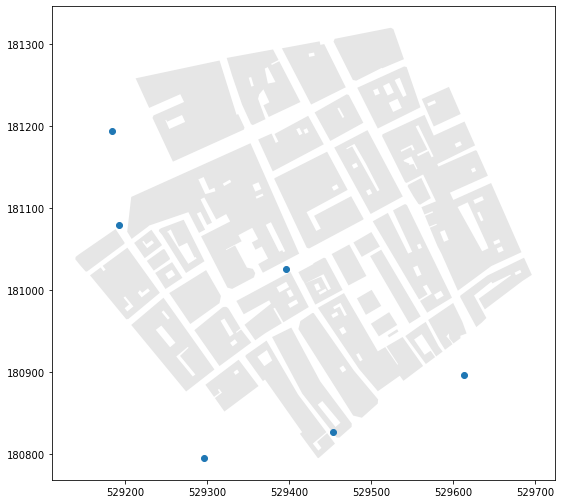

In [8]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps.plot(ax=ax)

# Accessing Shapely geometries from Geopandas <a id='access'></a>

As we've seen the `geometry` Series in our GeoDataFrames holds the spatial information. Each row in the GDFs is an object located in space. When working with Shapely we will sometimes want to be able to access those spatial objects directly. 

So before we go on to see how to use Shapely, let's revise how we can access data from a GeoDataFrame in different ways. 

From above, we can see that the first pump in the `pumps` GDF is the Broad Street pump. We could access that pump either using the position in the GDF (position `0`) or we could query using the name of the pump (i.e. `pumps['name']=='Broad St Pump'`). 

To return the Broad St. pump as a `DataFrame` we could do one of two things:

In [9]:
#returns #DataFrame
p0df_a = pumps.iloc[[0],]                        #asks for 0 row, all columns
p0df_b = pumps[pumps['name']=='Broad St Pump']

Check what we have produced:

In [10]:
print(p0df_a)
print(p0df_b)

print(type(p0df_a))
print(type(p0df_b))

   ID              x              y           name  \
0   1  529396.539395  181025.063047  Broad St Pump   

                        geometry  
0  POINT (529396.539 181025.063)  
   ID              x              y           name  \
0   1  529396.539395  181025.063047  Broad St Pump   

                        geometry  
0  POINT (529396.539 181025.063)  
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


Accessing as a DataFrame is useful for example when we want to do a simple plot using matplotlib:

<AxesSubplot:>

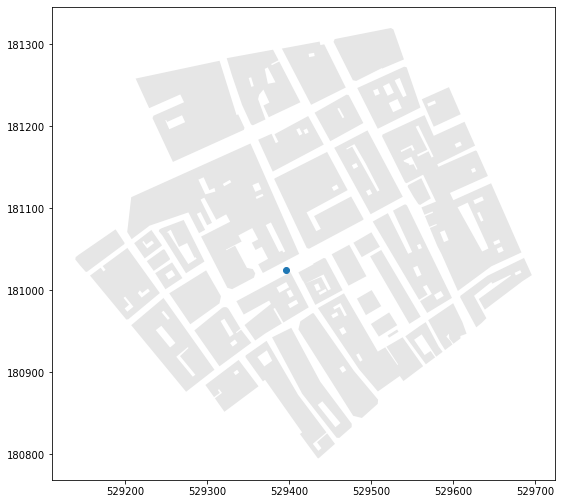

In [11]:
#locate the Broad Street Pump
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps[pumps['name']=='Broad St Pump'].plot(ax=ax)   

#or that last line could have been
#p0df_b.plot(ax=ax)

To get the first pump as a `Series` we do something slightly different:

In [12]:
#returns Series
p0s_a = pumps.iloc[0]      #asks for 0th row
p0s_b = pumps[pumps['name']=='Broad St Pump'].squeeze()  #squeeze from DF to Series

Note how the approach using a query uses [the Pandas `squeeze` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.squeeze.html) to return a `Series` rather than a `DataFrame`:

In [13]:
print(p0s_a)
print(p0s_b)

print(type(p0s_a))
print(type(p0s_b))

ID                                                    1
x                                         529396.539395
y                                         181025.063047
name                                      Broad St Pump
geometry    POINT (529396.5393954368 181025.0630474603)
Name: 0, dtype: object
ID                                                    1
x                                         529396.539395
y                                         181025.063047
name                                      Broad St Pump
geometry    POINT (529396.5393954368 181025.0630474603)
Name: 0, dtype: object
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


We may not often want to access the `Series`, but it does lead us to the final way of accessing the locations info. 

Often when working with Shapely we won't want a `GeoDataFrame` or `Series` but instead we will want to get the shape object (in the `geometry` Series) directly. To get that we can do:

In [14]:
#returns geometry object
p0g_a = pumps['geometry'].iloc[0]
p0g_b = pumps[pumps['name']=='Broad St Pump']['geometry'].squeeze()

See how these build on the previous ways we accessed elements of the `pumps` GDF to get only a single cell in the table. To prove that these access the Shapely `geometry` object directly:

In [15]:
print(p0g_a)
print(p0g_b)

print(type(p0g_a))
print(type(p0g_b))

POINT (529396.5393954368 181025.0630474603)
POINT (529396.5393954368 181025.0630474603)
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>


Now we'll see how we can use Shapely methods with the shape objects to calculate and extract information about spatial relations between multiple shape objects. 

# Calculating Distances <a name ="distances"></a> 

First, let's do a simple calculation of the distance between points. For this we can use [Shapely's `distance` method](https://shapely.readthedocs.io/en/stable/manual.html#object.distance). 

To calculate the distance between Broad St Pump and Rupert St Pump we could do:

In [16]:
pumps['geometry'].iloc[0].distance(pumps['geometry'].iloc[3])

251.78252434361087

That's possibly the shortest line of code but to make it a little clearer let's split it out:

In [17]:
A=pumps['geometry'].iloc[0]
B=pumps['geometry'].iloc[3]

A.distance(B)

251.78252434361087

Hopefully that's clear how the `distance` method is used. But this approach means we need to know which row of the `pumps` GDF the pumps we want to compare are on. 

If we didn't know which rows they are one, we could use a different one of our approaches above to query by name:

In [18]:
A='Broad St Pump'
B='Rupert St Pump'

pumps[pumps['name']==A]['geometry'].squeeze().distance(pumps[pumps['name']==B]['geometry'].squeeze())

251.78252434361087

Or the same as the last block but splitting the code out differently:

In [19]:
pointA=pumps[pumps['name']=='Broad St Pump']['geometry'].squeeze()
pointB=pumps[pumps['name']=='Rupert St Pump']['geometry'].squeeze()

pointA.distance(pointB)

251.78252434361087

Finally, let's think about the number we have actually produced... 

The units of this number a metres. We know that because we know the units of the CRS the data are projected in (see <a href="#setup">Setup section</a> above). 

As these are metres, maybe we should be a little less precise (do we really think we can be precise to the nearest billionth of a mm?)

In [20]:
round(pointA.distance(pointB),1)

251.8

So, that's calculating the distance between Broad St. Pump and one other pump. What about the distance to multiple other pumps? We could use a loop to do that:

In [21]:
bsPump = pumps.loc[0,'geometry']

for i in pumps['geometry']:
    print(round(bsPump.distance(i),1))

0.0
211.1
271.5
251.8
206.7
251.2


Or, with a nicer format not knowing that Broad St Pump is in the first row of the GDF:

In [22]:
focalPump = pumps[pumps['name']=='Broad St Pump']['geometry'].squeeze()

print('The distance between Broad St Pump and ')
for index, row in pumps.iterrows():
    
    print('{0} is {1} m'.format(
        row['name'],
        round(focalPump.distance(row['geometry']),1)        
    ))

The distance between Broad St Pump and 
Broad St Pump is 0.0 m
Great Malborough Pump is 211.1 m
Ramilies Place Pump is 271.5 m
Rupert St Pump is 251.8 m
Brewer St Pump is 206.7 m
Warwick St Pump is 251.2 m


# Creating Buffers <a name ="buff"></a> 

Buffers are created through the process of buffering [[source](https://docs.qgis.org/3.16/en/docs/gentle_gis_introduction/vector_spatial_analysis_buffers.html)]:

> Buffering usually creates two areas: one area that is within a specified distance to selected real world features and the other area that is beyond. 

We can create buffers around points, lines or polygons. The resulting object is always a polygon. Here, we'll create buffers around the Soho pumps (these might, for example, help to think about and visualise which buildings might have used each pump, based on proximity). 

To create a buffer we can use [Shapely's buffer method](https://shapely.readthedocs.io/en/stable/manual.html#object.buffer). We can do this for multiple spatial objects at the same time. For example, to create a 200m buffer around all pumps and adding the new buffer polygons to the `pumps` GeoDataFrame:

In [23]:
pumps['buffer']=pumps.buffer(200)

Let's check what we have created:

In [24]:
pumps.head()

,ID,x,y,name,geometry,buffer
0,1,529396.539395,181025.063047,Broad St Pump,POINT (529396.539 181025.063),"POLYGON ((529596.539 181025.063, 529595.576 18..."
1,2,529192.537868,181079.391380,Great Malborough Pump,POINT (529192.538 181079.391),"POLYGON ((529392.538 181079.391, 529391.575 18..."
2,3,529183.739766,181193.735013,Ramilies Place Pump,POINT (529183.740 181193.735),"POLYGON ((529383.740 181193.735, 529382.777 18..."
3,5,529613.205238,180896.804121,Rupert St Pump,POINT (529613.205 180896.804),"POLYGON ((529813.205 180896.804, 529812.242 18..."
4,6,529453.585995,180826.353152,Brewer St Pump,POINT (529453.586 180826.353),"POLYGON ((529653.586 180826.353, 529652.623 18..."


And quickly visualise the buffers:

<AxesSubplot:>

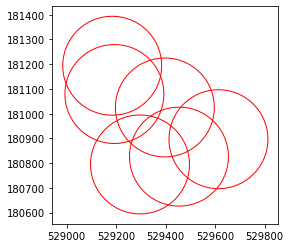

In [25]:
pumps['buffer'].plot(facecolor='none',edgecolor='red')

That visualisation is a little abstract, so let's add some context:

<AxesSubplot:>

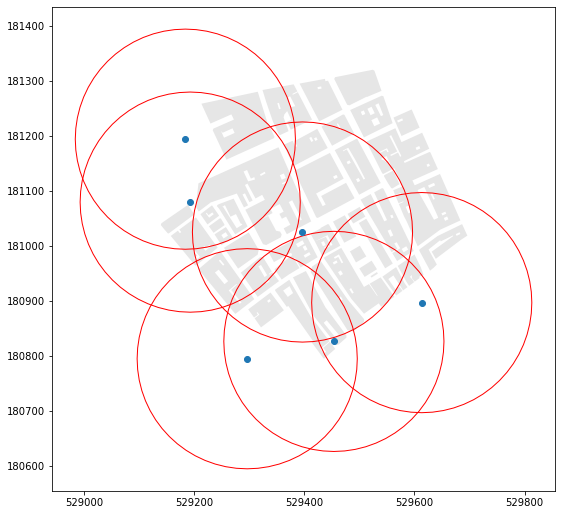

In [26]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['buffer'].plot(ax=ax, facecolor='none', edgecolor='red')
pumps['geometry'].plot(ax=ax)

These buffers are circular as they are around points. We could check the buffer is indeed 200m by, for example, calculating the area of buffer polygon and comparing to what it should be if it is a perfect circle. 

First, we can calculate polygon area for one of the buffers using [Shapely's `area` method](https://shapely.readthedocs.io/en/stable/manual.html#object.area).:

In [27]:
pumps['buffer'].iloc[0].area

125461.93962183727

Now calculate the area of a circle with 200m radius:

In [28]:
3.14 * 200**2

125600.0

The values are not identical, but they are very similar. The difference is due to the precision used when creating the buffer (you could play with the `resolution` argument of the `buffer` method to see the effect). 

# Within and Contains <a name ="wc"></a> 

These relations compare whether one object is entirely encompased (in space) by another:
- `within` is from the perspective of the object that would be encompassed
- `contains` is from the perspective of the object that would be doing the encompasing

For example, for our Soho cholera outbreak example we might ask,
- is Broad St Pump _within_ a 200m buffer of another pump?
- how many 200m buffers _contain_ the Broad St Pump?

Let's investgate these questions using Shapely's [`within`](https://shapely.readthedocs.io/en/stable/manual.html?highlight=within#object.within) and [`contains`](https://shapely.readthedocs.io/en/stable/manual.html?highlight=contains#object.contains) methods. (You might check the last visualisation we made before running the next lines of code to see if you can identify the answers first). 

The syntax for these methods is quite straight-forward:
- `A.within(B)` returns `TRUE` if object A is within object B, otherwise `FALSE 
- `A.contains(B)` returns `TRUE` if object A contains object B, otherwise `FALSE 

First, _is Broad St Pump within a 200m buffer of another pump?_ To answer this, we'll use a loop to repeated use the `within` method for the Broad St Pump point as compared to all the buffer polygons:

In [29]:
focalName='Broad St Pump'
focalPump = pumps[pumps['name']==focalName]['geometry'].squeeze()

for i in pumps['buffer']:
    
    print(focalPump.within(i))

True
False
False
False
False
False


Or with a nice format we could only print when `TRUE`:

In [30]:
focalName='Broad St Pump'
focalPump = pumps[pumps['name']==focalName]['geometry'].squeeze()

for index, row in pumps.iterrows():
    
    if focalPump.within(row['buffer']):
        print('{0} is within the buffer of {1}'.format(
            row['name'],
            focalName)
        )

Broad St Pump is within the buffer of Broad St Pump


So Broad St Pump is within only its own 200m buffer. Check that makes sense by looking at the last visualisation we printed. 

Let's try a different pump. We can do that with just one edit of our last code block: 

In [31]:
focalName='Rupert St Pump'
focalPump = pumps[pumps['name']==focalName]['geometry'].squeeze()

for index, row in pumps.iterrows():
    
    if focalPump.within(row['buffer']):
        print('{0} is within the buffer of {1}'.format(
            focalName,
            row['name'])
        )

Rupert St Pump is within the buffer of Rupert St Pump
Rupert St Pump is within the buffer of Brewer St Pump


Now, our second question: _how many 200m buffers contain the Broad St Pump?_

This time we'll create a function so that we can re-use the code without having to type it all out again. 

In [32]:
def countBuffersContaining(pumpName, pumpsGDF):

    focalPump = pumpsGDF[pumpsGDF['name']==pumpName]['geometry'].squeeze()
    contained = []

    for index, row in pumpsGDF.iterrows():

        if row['buffer'].contains(focalPump):
            contained.append(row['name'])

    if(len(contained) == 0):
        print('No buffers contain {0}'.format(pumpName))
    elif(len(contained) == 1):
        print('1 buffer contains {0}'.format(pumpName))
        print('That buffer is {0}'.format(contained[0]))       
    else:
        print('{0} buffers contain {1}. They are:'.format(len(contained),pumpName))
        for i in contained:
            print(i)
        

Now we can use our function as follows to answer our question:

In [33]:
countBuffersContaining('Broad St Pump', pumps)

1 buffer contains Broad St Pump
That buffer is Broad St Pump


So only the Broad St Pump buffer contains the Broad St Pump. 

What about a different pump buffer:

In [34]:
countBuffersContaining('Rupert St Pump', pumps)

2 buffers contain Rupert St Pump. They are:
Rupert St Pump
Brewer St Pump


# Overlaps <a id='overlap'></a>

[Shapely's definition](https://shapely.readthedocs.io/en/stable/manual.html?highlight=overlap#object.overlaps) of an overlap is complicated and requires some detailed understanding of how the package represents space:

> geometries have more than one but not all points in common, have the same dimension, and the intersection of the interiors of the geometries has the same dimension as the geometries themselves.

So let's visualise some overlaps in our data. 

In the last visualisation we used empty circles to show the limit of the buffer, but it did not show very well the area contained within the buffer. To do that we could use some colour. Furthermore, if we make that colour translucent we'll be able to see the context of the area over which that buffer covers _and how the buffers overlap. 

So, using the `facecolor` and `alpha` arguments of the matplotlib's `plot` method:

<AxesSubplot:>

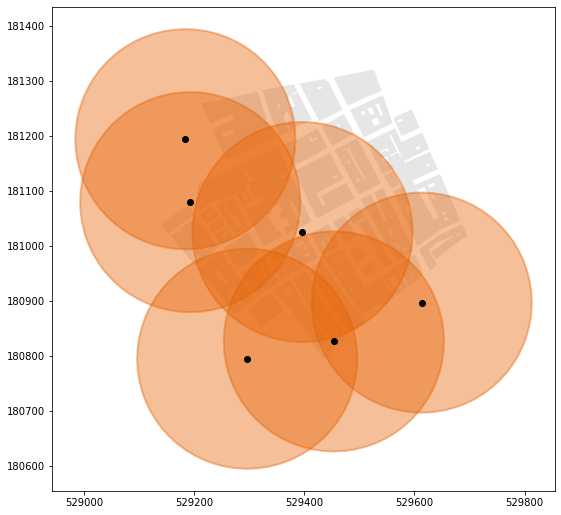

In [35]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['buffer'].plot(ax=ax, linewidth=2, edgecolor='#e66101', facecolor='#e66101', alpha=0.4)
pumps['geometry'].plot(ax=ax, color='black')

[Shapely's `overlaps`method](https://shapely.readthedocs.io/en/stable/manual.html?highlight=overlaps#object.overlaps) has similar syntax to the other methods we've used in this notebook: `A.overlaps(B)` will return `TRUE` if the two objects overlap, and `FALSE` if not. 

For example, from the last visualisation, the Broad St Pump buffer looks like it overlaps all other buffers. So for any combination of buffers including Broad St Buffer, we should return `TRUE`

In [36]:
randomPump = pumps.sample()
print(randomPump['name'].squeeze())

randomBuffer = randomPump['buffer'].squeeze()   #use Pandas sample to select a buffer at random
bsBuffer = pumps[pumps['name']=='Broad St Pump']['buffer'].squeeze()  #set the Broad St Pump buffer
bsBuffer.overlaps(randomBuffer)

Broad St Pump


False

Let's create a short function to allow us to compare two of our buffers by name (checking we have spelled pump names corectly):

In [37]:
def tidyBufferOverlaps(buff1, buff2, pumpsGDF):

    A = pumpsGDF[pumpsGDF['name']==buff1]
    B = pumpsGDF[pumpsGDF['name']==buff2]
    
    Abuf = A['buffer'].squeeze()
    Bbuf = B['buffer'].squeeze()
    
    if len(A)==0 or len(B)==0:
        print('Pump name incorrectly specified')
    else:
        result = Abuf.overlaps(Bbuf)
        print(result)

And now we can use to check overlaps:

In [38]:
tidyBufferOverlaps('Rupert St Pump', 'Ramilies Place Pump', pumps)

False


The final visualisation below adds pump names helping us to check that the overlaps function above really is working. 

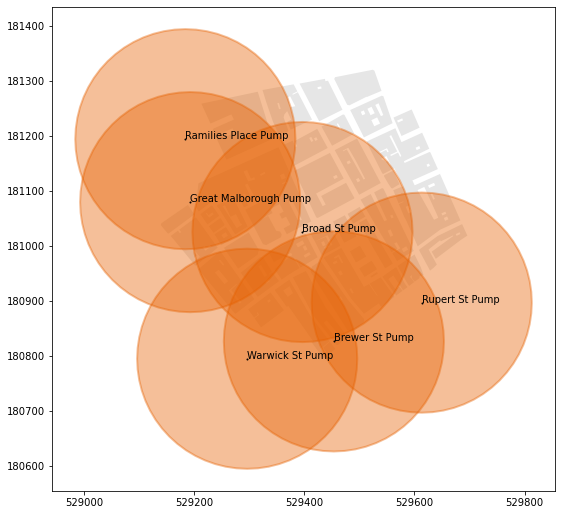

In [39]:
f, ax = plt.subplots(1, figsize=(9, 9))
blocks.plot(ax=ax, facecolor='0.9', linewidth=0)
pumps['buffer'].plot(ax=ax, linewidth=2, edgecolor='#e66101', facecolor='#e66101', alpha=0.4)
pumps['geometry'].plot(ax=ax, color='black', markersize=1)

for index, row in pumps.iterrows():
    #help from here https://stackoverflow.com/a/51689106
    plt.annotate(row['name'], xy=(row['geometry'].coords[0][0],row['geometry'].coords[0][1]))  


Think about how these simple (circular) buffers are useful for understanding which pump people in Soho might have visited to get their water in 1854. What might happen in the overlapping areas?

# Further Activities

- Explore [other Shapely relationship functions](https://shapely.readthedocs.io/en/latest/manual.html?highlight=crosses#predicates-and-relationships), such as `crosses` and `intersects`
- Continue to next notebook to learn more [Spatial Operations](https://developers.arcgis.com/python/guide/part3-spatial-operations-on-geometries/)
- Investigate [Contiguity Spatial Weights](https://geographicdata.science/book/notebooks/04_spatial_weights.html#contiguity-weights) to see how they incorporate the touches relations

# Credits!

## Contributors:
The following individual(s) have contributed to these teaching materials: James Millington (james.millington@kcl.ac.uk).

## License
These teaching materials are licensed under a mix of [The MIT License](https://opensource.org/licenses/mit-license.php) and the [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 license](https://creativecommons.org/licenses/by-nc-sa/4.0/).